# **Chargement des données préparées**

In [2]:
# Autres imports
from tqdm import tqdm
import numpy as np 
import pandas as pd
import os
import gc

import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import clear_output, display
from pprint import pprint

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input as efficientnet_preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import Model

In [ ]:
# Définit le nombre de coeurs utilisés à 10
os.environ['LOKY_MAX_CPU_COUNT'] = '10'

Le dataframe flipkart a été chargé lors du préprocessing dans les globals, réassignons le au nom flipkart pour plus de clarté.

In [4]:
image_df = pd.read_pickle('flipkart_cleaned.pkl')
image_df.drop(columns=['product_name', 'description'], inplace=True)
print(image_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1050 entries, 0 to 1049
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   image   1050 non-null   object  
 1   class   1050 non-null   category
dtypes: category(1), object(1)
memory usage: 9.7+ KB
None


In [5]:
# Assigne le nombre de classes
n_classes = image_df['class'].nunique()

# Assigne la liste des classes
labels = list(image_df['class'].unique())

# **Séparation des données en train-test-split**

In [6]:
# train test split avec un jeu de test de 20%
X_train, X_test, y_train, y_test = train_test_split(image_df['image'], image_df['class'], test_size=0.2, random_state=314, stratify=image_df['class'])

# Regroupement des données en dataframe de train et de test
train = pd.concat([X_train, y_train], axis=1)
test = pd.concat([X_test, y_test], axis=1)

# **Test des différents scénarios de modélisation**

## **Fonctions de modélisation**

In [7]:
def create_test_generator(data, image_size=(224, 224), batch_size=32, preprocess=efficientnet_preprocess_input):
    # Création d'un Image Data Generator avec la fonction de preprocessing d'EfficientNet
    datagen = ImageDataGenerator(
        preprocessing_function=preprocess
    )

    # Création du générateur de données à partir du dataframe de test
    test_generator = datagen.flow_from_dataframe(
        data,
        directory='images/',
        x_col='image',
        y_col='class',
        target_size=image_size,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True
    )

    # Retourne le datagenerator de test
    return test_generator

In [8]:
def compile_and_fit(model, N_EPOCHS, LEARNING_RATE, scenario, data_augmentation_params=None, preprocess=efficientnet_preprocess_input):
    # Vérifie que model est bien un modèle Keras
    assert isinstance(model, tf.keras.Model), 'model doit être un modèle Keras'
    # Vérifie que N_EPOCHS est bien un entier
    assert isinstance(N_EPOCHS, int), 'N_EPOCHS doit être un entier'
    # Vérifie que LEARNING_RATE est bien un flottant
    assert isinstance(LEARNING_RATE, float), 'LEARNING_RATE doit être un flottant'
    # Vérifie que scenario est bien une chaîne de caractères
    assert isinstance(scenario, str), 'scenario doit être une chaîne de caractères'
    # Vérifie que data_augmentation_params est bien un dictionnaire ou None
    assert data_augmentation_params is None or isinstance(data_augmentation_params, dict), 'data_augmentation_params doit être un dictionnaire ou None'

    # Assigne les paramètres de data augmentation ou pas pour le datagenerator
    if data_augmentation_params is not None:
        datagen = ImageDataGenerator(
            preprocessing_function=preprocess,
            validation_split=0.2,
            **data_augmentation_params
        )
    else:
        datagen = ImageDataGenerator(
        preprocessing_function=preprocess,
        validation_split=0.2
        )

    # Crée les générateurs de données du train à partir du dataframe de train
    train_generator = datagen.flow_from_dataframe(
        dataframe=train,
        directory='images',
        x_col='image',
        y_col='class',
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical',
        subset='training'
    )

    # Crée les générateurs de données de validation à partir du dataframe de train
    validation_generator = datagen.flow_from_dataframe(
        dataframe=train,
        directory='images',
        x_col='image',
        y_col='class',
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical',
        subset='validation'
    )

    # Compile le modèle avec le LEARNING_RATE désiré
    model.compile(
        optimizer=Adam(learning_rate=LEARNING_RATE),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    # Définir le callback EarlyStopping
    early_stopping = EarlyStopping(
    monitor='val_loss',  # Surveiller la perte de validation (ou 'val_accuracy' pour la précision de validation)
    patience=5,          # Arrêter l'entraînement après 5 epochs sans amélioration
    min_delta=0.001,     # Seuil de tolérance pour l'amélioration
    mode='min',          # Utiliser 'min' pour la perte (ou 'max' pour 'val_accuracy')
    verbose=1            # Afficher un message lorsque l'entraînement est arrêté
    )

    # Définir le callback pour sauvegarder les poids du modèle
    checkpoint = ModelCheckpoint(
        scenario+'_best_model.weights.h5',
        save_weights_only=True,
        save_best_only=True,
        monitor='val_loss',
        mode='min',
        verbose=1)

    # Entraîne le modèle
    history = model.fit(
        train_generator,
        validation_data=validation_generator,
        epochs=N_EPOCHS,
        callbacks=[early_stopping, checkpoint]
    )

    # Retourne l'historique de l'entraînement
    return history

## **EfficientNetB0**

### **Initialisation du dictionnaire de modèle et du test generator**

In [9]:
# Initialisation du dictionnaire avec les paramètres du modèle
model_params = dict()

In [10]:
# Création du génération de données de test
test_generator = create_test_generator(test)

Found 210 validated image filenames belonging to 7 classes.


In [11]:
# Affiche les couches de sortie du modèle
print("Les couches de sortie/output du modèle par défaut sont :")
pprint(EfficientNetB0(include_top=True, weights=None).layers[-3:])

Les couches de sortie/output du modèle par défaut sont :
[<GlobalAveragePooling2D name=avg_pool, built=True>,
 <Dropout name=top_dropout, built=True>,
 <Dense name=predictions, built=True>]


### **SCENARIO 1 - From scratch**

In [40]:
# Définir les paramètres du modèle pour le scénario 1
scenario='1'
data_augmentation_params = None
LEARNING_RATE = 1e-3
N_EPOCHS = 20

# Enregistre les paramètres du modèle
model_params[scenario] = {
    'include_top': True,
    'weights': None,
    'input_shape': (224, 224, 3),
    'classes': n_classes,
    'classifier_activation': 'softmax'
}

# Charge le modèle EfficientNetB0
model = EfficientNetB0(**model_params[scenario])

# Rends les couches entraînables
model.trainable=True

# Entraîne le modèle et retourne les résultats
history = compile_and_fit(model, N_EPOCHS, LEARNING_RATE, scenario=scenario)

Found 672 validated image filenames belonging to 7 classes.
Found 168 validated image filenames belonging to 7 classes.
Epoch 1/20


c:\Users\BS6517\Documents_local\projet_6\oc_projet_6\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.1903 - loss: 4.3861

c:\Users\BS6517\Documents_local\projet_6\oc_projet_6\.venv\Lib\site-packages\PIL\Image.py:3368: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(



Epoch 1: val_loss improved from inf to 1.95417, saving model to 1_best_model.weights.h5
21/21 ━━━━━━━━━━━━━━━━━━━━ 165s 6s/step - accuracy: 0.1895 - loss: 4.3706 - val_accuracy: 0.1190 - val_loss: 1.9542
Epoch 2/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.1953 - loss: 3.3320
Epoch 2: val_loss did not improve from 1.95417
21/21 ━━━━━━━━━━━━━━━━━━━━ 125s 6s/step - accuracy: 0.1943 - loss: 3.3314 - val_accuracy: 0.1190 - val_loss: 2.1431
Epoch 3/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.2456 - loss: 2.6837
Epoch 3: val_loss did not improve from 1.95417
21/21 ━━━━━━━━━━━━━━━━━━━━ 118s 5s/step - accuracy: 0.2455 - loss: 2.6892 - val_accuracy: 0.1190 - val_loss: 2.2233
Epoch 4/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.2203 - loss: 3.2431
Epoch 4: val_loss did not improve from 1.95417
21/21 ━━━━━━━━━━━━━━━━━━━━ 119s 5s/step - accuracy: 0.2213 - loss: 3.2274 - val_accuracy: 0.1310 - val_loss: 2.0469
Epoch 5/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accura

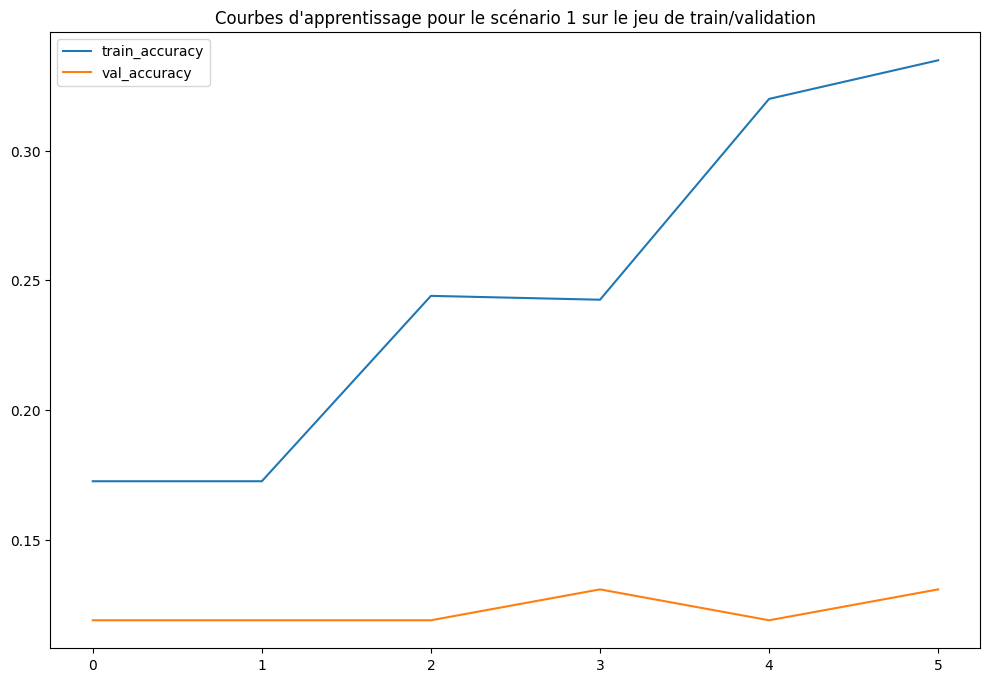

In [42]:
# Affiche les courbes d'apprentissage
plt.figure(figsize=(12, 8))
plt.title("Courbes d\'apprentissage pour le scénario 1 sur le jeu de train/validation")
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.show()

In [43]:
# Définit le nom du modèle à charger
model_name = scenario+'_best_model.weights.h5'

# Charger les poids du modèle sauvegardés
model.load_weights(model_name)

# Évaluer le modèle avec les poids chargés
score = model.evaluate(test_generator)
print(f"Test loss: {score[0]}")
print(f"Test accuracy: {score[1]}")

c:\Users\BS6517\Documents_local\projet_6\oc_projet_6\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


7/7 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.1478 - loss: 1.9685
Test loss: 1.9630519151687622
Test accuracy: 0.1428571492433548


### **SCENARIO 2a - Transfer Learning avec entraînement de l'output**

In [44]:
# SCENARIO 2A : On utilise les poids pré-entraînés sur ImageNet ET on reproduit les dernières couches de l'output du modèle
scenario = '2a'
data_augmentation_params = None
LEARNING_RATE = 1e-3
N_EPOCHS = 20

# Enregistre les paramètres du modèle
model_params[scenario] = {
    'include_top': False,
    'weights': 'imagenet',
    'input_shape': (224, 224, 3)
}

# Charge le modèle EfficientNetB0
model = EfficientNetB0(**model_params[scenario])

# Gèle toutes les couches du modèle
model.trainable = False

# Affiche les couches du modèle d'entrée et de sortie
print("Input: ", model.input)
print("Output: ", model.output)

# Ajoute les dernières couches denses du modèle
x = tf.keras.layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.2, name='top_dropout')(x)
predictions = tf.keras.layers.Dense(n_classes, activation='softmax', name='predictions')(x)

# Crée un modèle à partir des inputs et des outputs
model = Model(inputs=model.input, outputs=predictions)

# Entraine le modèle et affiche les résultats
history = compile_and_fit(model, N_EPOCHS, LEARNING_RATE, scenario=scenario)

Input:  <KerasTensor shape=(None, 224, 224, 3), dtype=float32, sparse=None, name=keras_tensor_3111>
Output:  <KerasTensor shape=(None, 7, 7, 1280), dtype=float32, sparse=False, name=keras_tensor_3348>
Found 672 validated image filenames belonging to 7 classes.
Found 168 validated image filenames belonging to 7 classes.
Epoch 1/20


c:\Users\BS6517\Documents_local\projet_6\oc_projet_6\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3295 - loss: 1.9892

c:\Users\BS6517\Documents_local\projet_6\oc_projet_6\.venv\Lib\site-packages\PIL\Image.py:3368: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(



Epoch 1: val_loss improved from inf to 1.03947, saving model to 2a_best_model.weights.h5
21/21 ━━━━━━━━━━━━━━━━━━━━ 47s 2s/step - accuracy: 0.3367 - loss: 1.9679 - val_accuracy: 0.7500 - val_loss: 1.0395
Epoch 2/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7621 - loss: 0.7383
Epoch 2: val_loss improved from 1.03947 to 0.75877, saving model to 2a_best_model.weights.h5
21/21 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.7632 - loss: 0.7342 - val_accuracy: 0.8095 - val_loss: 0.7588
Epoch 3/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8390 - loss: 0.4627
Epoch 3: val_loss improved from 0.75877 to 0.65534, saving model to 2a_best_model.weights.h5
21/21 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.8392 - loss: 0.4627 - val_accuracy: 0.8274 - val_loss: 0.6553
Epoch 4/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 959ms/step - accuracy: 0.8773 - loss: 0.3997
Epoch 4: val_loss improved from 0.65534 to 0.59660, saving model to 2a_best_model.weights.h5
21/21 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/

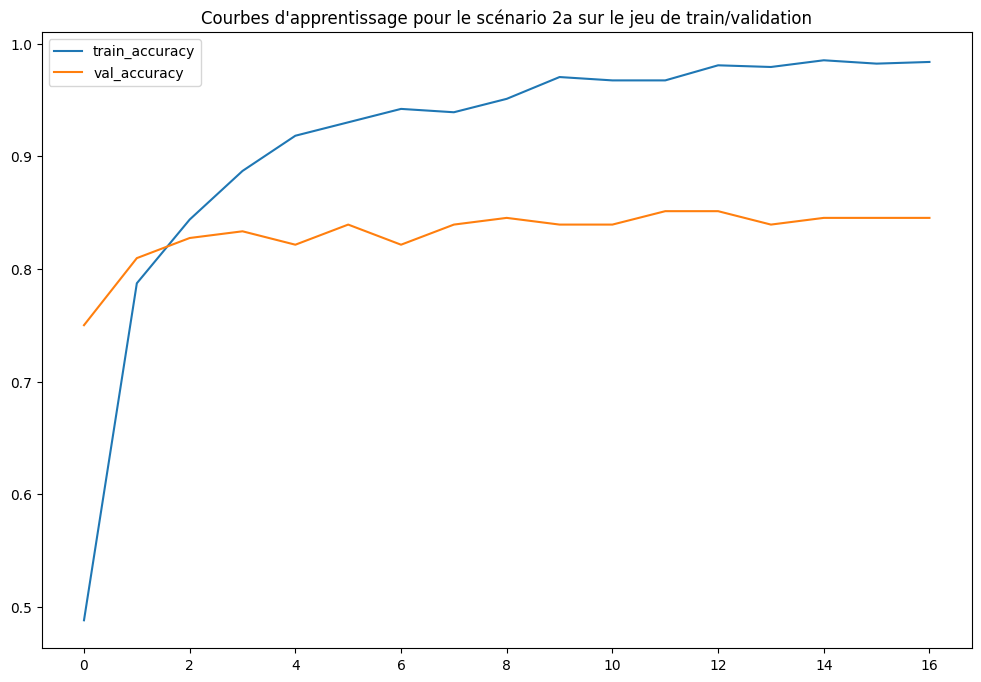

In [45]:
# Affiche les courbes d'apprentissage
plt.figure(figsize=(12, 8))
plt.title(f"Courbes d'apprentissage pour le scénario {scenario} sur le jeu de train/validation")
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.show()

In [46]:
# Définit le nom du modèle à charger
model_name = scenario+'_best_model.weights.h5'

# Charger les poids du modèle sauvegardés
model.load_weights(model_name)

# Évaluer le modèle avec les poids chargés
score = model.evaluate(test_generator)
print(f"Test loss: {score[0]}")
print(f"Test accuracy: {score[1]}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 945ms/step - accuracy: 0.7459 - loss: 0.7571
Test loss: 0.6513480544090271
Test accuracy: 0.7952380776405334


### **SCENARIO 2b - Transfer Learning avec l'output modifié avec G_AVG_POOL + 1xDENSE FC**

In [47]:
# SCENARIO 2B : On utilise les poids pré-entraînés sur ImageNet ET avec une sortie sans régularisation avec deux dense hidden layer.
scenario = '2b'
data_augmentation_params = None
LEARNING_RATE = 1e-3
N_EPOCHS = 20

# Enregistre les paramètres du modèle
model_params[scenario] = {
    'include_top': False,
    'weights': 'imagenet',
    'input_shape': (224, 224, 3)
}

# Charge le modèle EfficientNetB0
model = EfficientNetB0(**model_params[scenario])

# Gèle toutes les couches du modèle
model.trainable = False

# Affiche les couches du modèle d'entrée et de sortie
print("Input: ", model.input)
print("Output: ", model.output)

# Ajoute les dernières couches denses du modèle
x = tf.keras.layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
predictions = tf.keras.layers.Dense(n_classes, activation='softmax', name='predictions')(x)

# Crée un modèle à partir des inputs et des outputs
model = Model(inputs=model.input, outputs=predictions)

# Entraine le modèle et affiche les résultats
history = compile_and_fit(model, N_EPOCHS, LEARNING_RATE, scenario=scenario)

Input:  <KerasTensor shape=(None, 224, 224, 3), dtype=float32, sparse=None, name=keras_tensor_3353>
Output:  <KerasTensor shape=(None, 7, 7, 1280), dtype=float32, sparse=False, name=keras_tensor_3590>
Found 672 validated image filenames belonging to 7 classes.
Found 168 validated image filenames belonging to 7 classes.
Epoch 1/20


c:\Users\BS6517\Documents_local\projet_6\oc_projet_6\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 931ms/step - accuracy: 0.6323 - loss: 1.0774

c:\Users\BS6517\Documents_local\projet_6\oc_projet_6\.venv\Lib\site-packages\PIL\Image.py:3368: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(



Epoch 1: val_loss improved from inf to 0.47680, saving model to 2b_best_model.weights.h5
21/21 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.6383 - loss: 1.0618 - val_accuracy: 0.8869 - val_loss: 0.4768
Epoch 2/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9554 - loss: 0.1544
Epoch 2: val_loss improved from 0.47680 to 0.44720, saving model to 2b_best_model.weights.h5
21/21 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - accuracy: 0.9552 - loss: 0.1540 - val_accuracy: 0.8690 - val_loss: 0.4472
Epoch 3/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 988ms/step - accuracy: 0.9763 - loss: 0.0754
Epoch 3: val_loss improved from 0.44720 to 0.40177, saving model to 2b_best_model.weights.h5
21/21 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.9765 - loss: 0.0748 - val_accuracy: 0.8690 - val_loss: 0.4018
Epoch 4/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 956ms/step - accuracy: 0.9940 - loss: 0.0236
Epoch 4: val_loss did not improve from 0.40177
21/21 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.9941 - loss: 0.0235 - va

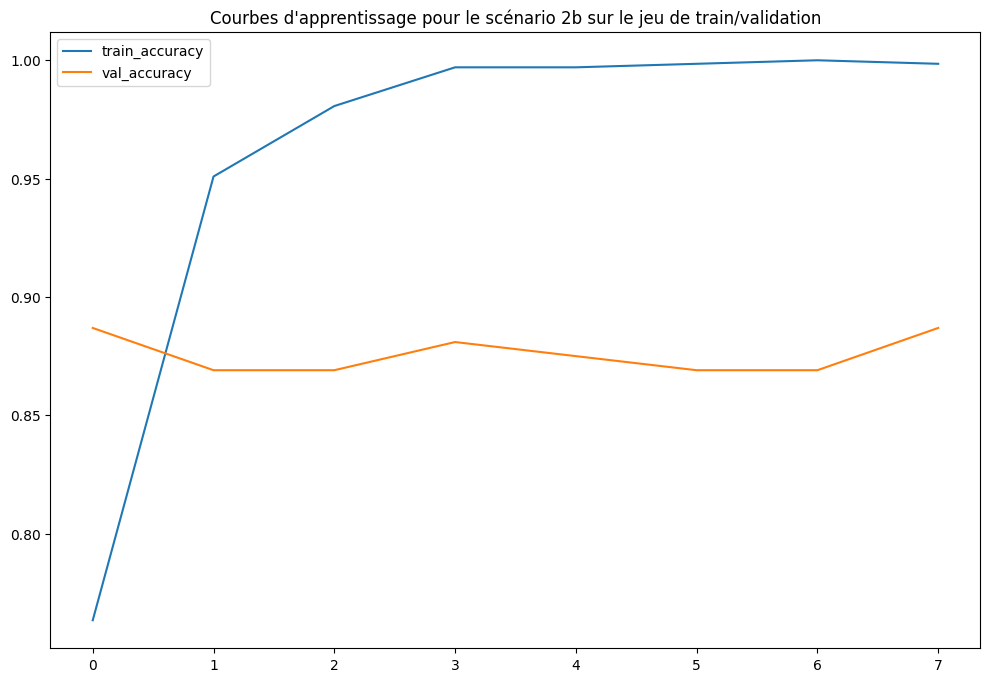

In [48]:
# Affiche les courbes d'apprentissage
plt.figure(figsize=(12, 8))
plt.title(f"Courbes d'apprentissage pour le scénario {scenario} sur le jeu de train/validation")
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.show()

In [49]:
# Définit le nom du modèle à charger
model_name = scenario+'_best_model.weights.h5'

# Charger les poids du modèle sauvegardés
model.load_weights(model_name)

# Évaluer le modèle avec les poids chargés
score = model.evaluate(test_generator)
print(f"Test loss: {score[0]}")
print(f"Test accuracy: {score[1]}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.7783 - loss: 0.8030
Test loss: 0.6663299798965454
Test accuracy: 0.8190476298332214


### **SCENARIO 2c - Transfer Learning avec entraînement de l'output custom G_AVG_POOL + 2X DENSE FC**

In [50]:
# SCENARIO 2c : On utilise les poids pré-entraînés sur ImageNet ET avec une sortie sans régularisation avec deux dense hidden layer.
scenario = "2c"
data_augmentation_params = None
LEARNING_RATE = 1e-3
N_EPOCHS = 20

# Enregistre les paramètres du modèle
model_params[scenario] = {
    'include_top': False,
    'weights': 'imagenet',
    'input_shape': (224, 224, 3)
}

# Charge le modèle EfficientNetB0
model = EfficientNetB0(**model_params[scenario])

# Gèle toutes les couches du modèle
model.trainable = False

# Affiche les couches du modèle d'entrée et de sortie
print("Input: ", model.input)
print("Output: ", model.output)

# Ajoute les dernières couches denses du modèle
x = tf.keras.layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
predictions = tf.keras.layers.Dense(n_classes, activation='softmax', name='predictions')(x)

# Crée un modèle à partir des inputs et des outputs
model = Model(inputs=model.input, outputs=predictions)

# Entraine le modèle et affiche les résultats
history = compile_and_fit(model, N_EPOCHS, LEARNING_RATE, scenario=scenario)

Input:  <KerasTensor shape=(None, 224, 224, 3), dtype=float32, sparse=None, name=keras_tensor_3594>
Output:  <KerasTensor shape=(None, 7, 7, 1280), dtype=float32, sparse=False, name=keras_tensor_3831>
Found 672 validated image filenames belonging to 7 classes.
Found 168 validated image filenames belonging to 7 classes.
Epoch 1/20


c:\Users\BS6517\Documents_local\projet_6\oc_projet_6\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 992ms/step - accuracy: 0.6284 - loss: 1.0893

c:\Users\BS6517\Documents_local\projet_6\oc_projet_6\.venv\Lib\site-packages\PIL\Image.py:3368: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(



Epoch 1: val_loss improved from inf to 0.43594, saving model to 2c_best_model.weights.h5
21/21 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.6334 - loss: 1.0762 - val_accuracy: 0.8571 - val_loss: 0.4359
Epoch 2/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 910ms/step - accuracy: 0.9184 - loss: 0.2176
Epoch 2: val_loss did not improve from 0.43594
21/21 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.9189 - loss: 0.2160 - val_accuracy: 0.8690 - val_loss: 0.4368
Epoch 3/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 913ms/step - accuracy: 0.9856 - loss: 0.0605
Epoch 3: val_loss did not improve from 0.43594
21/21 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.9855 - loss: 0.0607 - val_accuracy: 0.8571 - val_loss: 0.4553
Epoch 4/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 897ms/step - accuracy: 0.9970 - loss: 0.0169
Epoch 4: val_loss did not improve from 0.43594
21/21 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.9970 - loss: 0.0168 - val_accuracy: 0.8750 - val_loss: 0.4662
Epoch 5/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 855ms/step

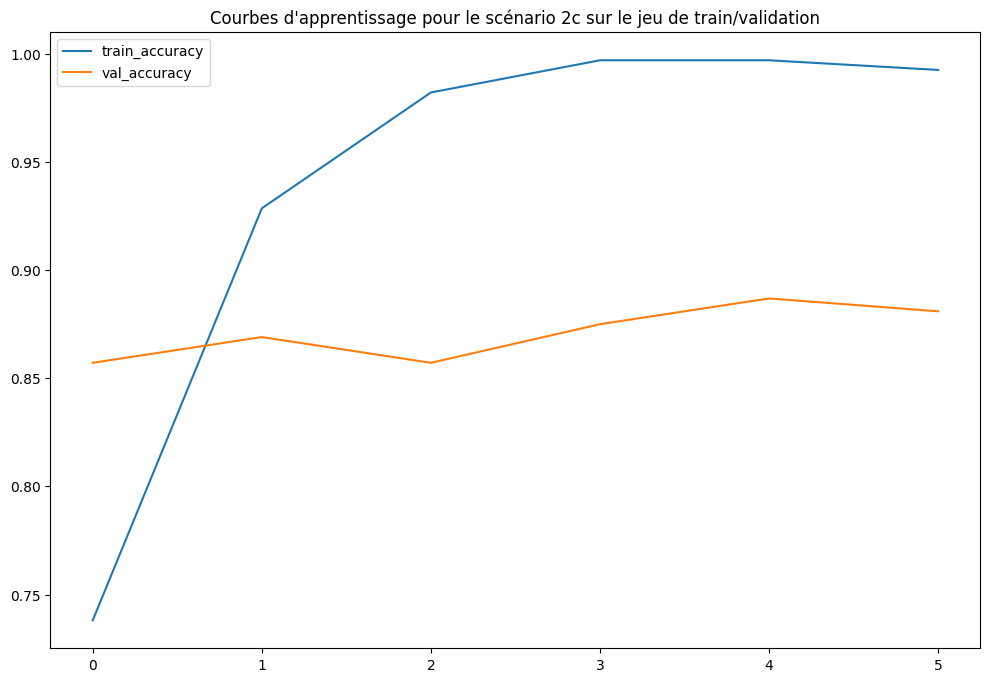

In [51]:
# Affiche les courbes d'apprentissage
plt.figure(figsize=(12, 8))
plt.title(f"Courbes d'apprentissage pour le scénario {scenario} sur le jeu de train/validation")
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.show()

In [52]:
# Définit le nom du modèle à charger
model_name = scenario+'_best_model.weights.h5'

# Charger les poids du modèle sauvegardés
model.load_weights(model_name)

# Évaluer le modèle avec les poids chargés
score = model.evaluate(test_generator)
print(f"Test loss: {score[0]}")
print(f"Test accuracy: {score[1]}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 869ms/step - accuracy: 0.7544 - loss: 0.7815
Test loss: 0.6523675918579102
Test accuracy: 0.8047618865966797


### **SCENARIO 3a - Entraîner le modèle 2b avec 4 couches suppl dégelées**

In [18]:
# SCENARIO 3 : Même modèle que le SCENARIO 2 mais on dégèle les dernières couches du modèle
scenario = '3a'
unfreezed_layers = -6
LEARNING_RATE = 1e-4
N_EPOCHS = 20
data_augmentation_params = None

# Enregistre les paramètres du modèle
model_params[scenario] = {
    'include_top': False,
    'weights': 'imagenet',
    'input_shape': (224, 224, 3)
}

# Charge le modèle EfficientNetB0
model = EfficientNetB0(**model_params[scenario])

# unfreeze layers
for layer in model.layers[unfreezed_layers:]:
    if not isinstance(layer, tf.keras.layers.BatchNormalization):
        layer.trainable = True

# Affiche les couches du modèle d'entrée et de sortie
print("Input: ", model.input)
print("Output: ", model.output)

# Ajoute les dernières couches denses du modèle
x = tf.keras.layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
predictions = tf.keras.layers.Dense(n_classes, activation='softmax', name='predictions')(x)

# Crée un modèle à partir des inputs et des outputs
model = Model(inputs=model.input, outputs=predictions)

# Entraine le modèle et affiche les résultats
history = compile_and_fit(model, N_EPOCHS, LEARNING_RATE, scenario=scenario, data_augmentation_params=data_augmentation_params)

Input:  <KerasTensor shape=(None, 224, 224, 3), dtype=float32, sparse=None, name=keras_tensor_722>
Output:  <KerasTensor shape=(None, 7, 7, 1280), dtype=float32, sparse=False, name=keras_tensor_959>
Found 672 validated image filenames belonging to 7 classes.
Found 168 validated image filenames belonging to 7 classes.
Epoch 1/20


c:\Users\BS6517\Documents_local\projet_6\oc_projet_6\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.3152 - loss: 1.8214

c:\Users\BS6517\Documents_local\projet_6\oc_projet_6\.venv\Lib\site-packages\PIL\Image.py:3368: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(



Epoch 1: val_loss improved from inf to 1.20866, saving model to 3a_best_model.weights.h5
21/21 ━━━━━━━━━━━━━━━━━━━━ 155s 6s/step - accuracy: 0.3220 - loss: 1.8129 - val_accuracy: 0.6845 - val_loss: 1.2087
Epoch 2/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.8426 - loss: 0.9414
Epoch 2: val_loss improved from 1.20866 to 0.72532, saving model to 3a_best_model.weights.h5
21/21 ━━━━━━━━━━━━━━━━━━━━ 112s 5s/step - accuracy: 0.8428 - loss: 0.9374 - val_accuracy: 0.8036 - val_loss: 0.7253
Epoch 3/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.8809 - loss: 0.5560
Epoch 3: val_loss improved from 0.72532 to 0.54457, saving model to 3a_best_model.weights.h5
21/21 ━━━━━━━━━━━━━━━━━━━━ 109s 5s/step - accuracy: 0.8813 - loss: 0.5533 - val_accuracy: 0.8274 - val_loss: 0.5446
Epoch 4/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.9293 - loss: 0.3190
Epoch 4: val_loss improved from 0.54457 to 0.50460, saving model to 3a_best_model.weights.h5
21/21 ━━━━━━━━━━━━━━━━━━━━ 110s 5s

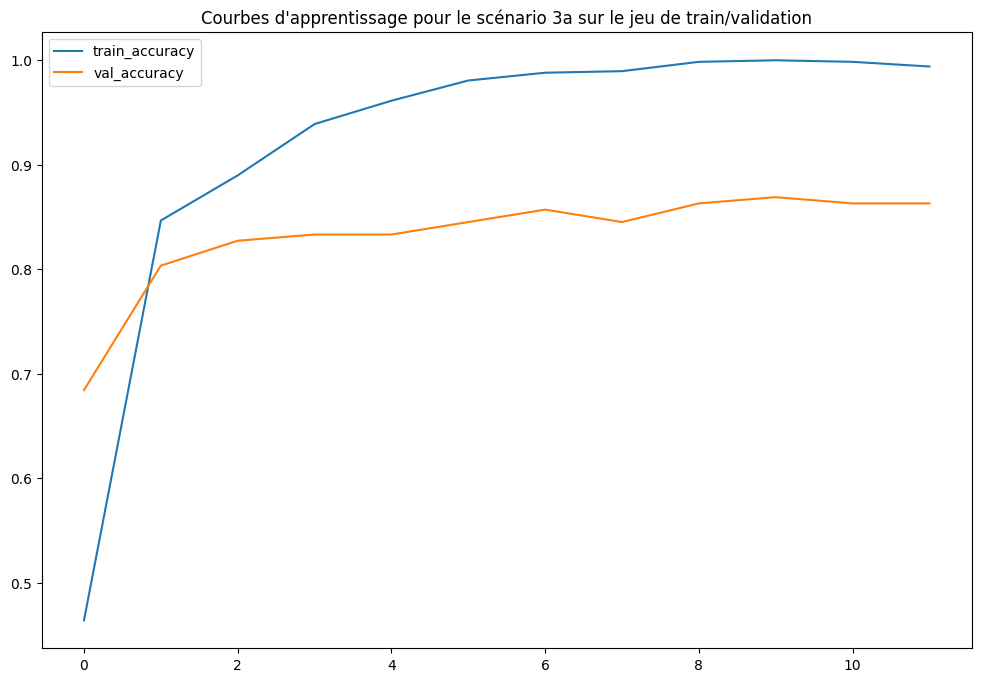

In [19]:
# Affiche les courbes d'apprentissage
plt.figure(figsize=(12, 8))
plt.title(f"Courbes d'apprentissage pour le scénario {scenario} sur le jeu de train/validation")
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.show()

In [20]:
# Définit le nom du modèle à charger
model_name = scenario+'_best_model.weights.h5'

# Charger les poids du modèle sauvegardés
model.load_weights(model_name)

# Évaluer le modèle avec les poids chargés
score = model.evaluate(test_generator)
print(f"Test loss: {score[0]}")
print(f"Test accuracy: {score[1]}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 962ms/step - accuracy: 0.7525 - loss: 0.8006
Test loss: 0.7047023773193359
Test accuracy: 0.776190459728241


### **SCENARIO 4a - Entraîner le modèle 3a AVEC Data augmentation**

In [12]:
# SCÉNARIO 4 : On utilise le même modèle que le SCENARIO 3 mais on rajoute de la data augmentation
scenario = '4a'
N_EPOCHS = 25
LEARNING_RATE = 1e-4
data_augmentation_params = {
    'width_shift_range': 0.2,
    'height_shift_range': 0.2,
    'zoom_range': 0.2,
    'horizontal_flip': True,
    'vertical_flip': True
}

# Enregistre les paramètres du modèle
model_params[scenario] = {
    'include_top': False,
    'weights': 'imagenet',
    'input_shape': (224, 224, 3)
}

# Charge le modèle EfficientNetB0
model = EfficientNetB0(**model_params[scenario])

# Affiche les couches du modèle d'entrée et de sortie
print("Input: ", model.input)
print("Output: ", model.output)

# Ajoute les dernières couches denses du modèle
x = tf.keras.layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
predictions = tf.keras.layers.Dense(n_classes, activation='softmax', name='predictions')(x)

# Crée un modèle à partir des inputs et des outputs
model = Model(inputs=model.input, outputs=predictions)

# Entraine le modèle et affiche les résultats
history = compile_and_fit(model, N_EPOCHS, LEARNING_RATE, scenario=scenario, data_augmentation_params=data_augmentation_params)

Input:  <KerasTensor shape=(None, 224, 224, 3), dtype=float32, sparse=None, name=keras_tensor_240>
Output:  <KerasTensor shape=(None, 7, 7, 1280), dtype=float32, sparse=False, name=keras_tensor_477>
Found 672 validated image filenames belonging to 7 classes.
Found 168 validated image filenames belonging to 7 classes.
Epoch 1/25


c:\Users\BS6517\Documents_local\projet_6\oc_projet_6\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.3019 - loss: 1.7947

c:\Users\BS6517\Documents_local\projet_6\oc_projet_6\.venv\Lib\site-packages\PIL\Image.py:3368: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(



Epoch 1: val_loss improved from inf to 1.28152, saving model to 4a_best_model.weights.h5
21/21 ━━━━━━━━━━━━━━━━━━━━ 142s 5s/step - accuracy: 0.3072 - loss: 1.7882 - val_accuracy: 0.6310 - val_loss: 1.2815
Epoch 2/25
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.7256 - loss: 1.0894
Epoch 2: val_loss improved from 1.28152 to 0.85542, saving model to 4a_best_model.weights.h5
21/21 ━━━━━━━━━━━━━━━━━━━━ 100s 5s/step - accuracy: 0.7258 - loss: 1.0867 - val_accuracy: 0.7738 - val_loss: 0.8554
Epoch 3/25
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.8143 - loss: 0.7006
Epoch 3: val_loss improved from 0.85542 to 0.64228, saving model to 4a_best_model.weights.h5
21/21 ━━━━━━━━━━━━━━━━━━━━ 97s 4s/step - accuracy: 0.8145 - loss: 0.6993 - val_accuracy: 0.8036 - val_loss: 0.6423
Epoch 4/25
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.8494 - loss: 0.4966
Epoch 4: val_loss improved from 0.64228 to 0.58196, saving model to 4a_best_model.weights.h5
21/21 ━━━━━━━━━━━━━━━━━━━━ 97s 4s/s

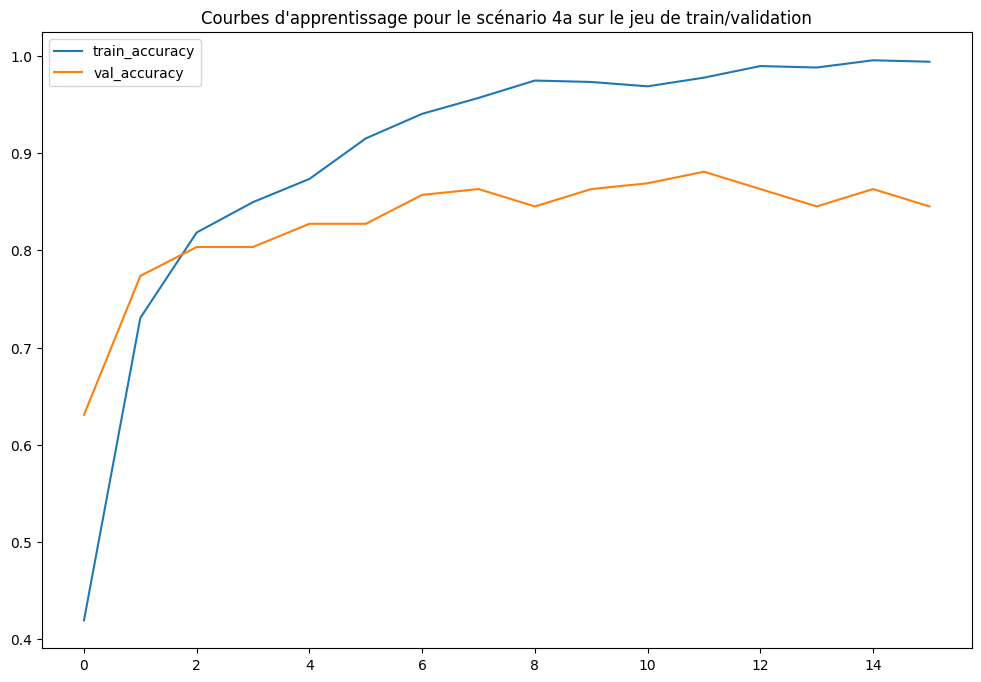

In [13]:
# Affiche les courbes d'apprentissage
plt.figure(figsize=(12, 8))
plt.title(f"Courbes d'apprentissage pour le scénario {scenario} sur le jeu de train/validation")
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.show()

In [14]:
# Définit le nom du modèle à charger
model_name = scenario+'_best_model.weights.h5'

# Charger les poids du modèle sauvegardés
model.load_weights(model_name)

# Évaluer le modèle avec les poids chargés
score = model.evaluate(test_generator)
print(f"Test loss: {score[0]}")
print(f"Test accuracy: {score[1]}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 763ms/step - accuracy: 0.7734 - loss: 0.7969
Test loss: 0.6908456683158875
Test accuracy: 0.7904762029647827


Le scénario avec la data augmentation a été testé mais n'a pas donné de meilleurs résultats que le scénario 3a.<br>


In [ ]:
from sklearn.preprocessing import StandardScaler
StandardScaler()